# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall22/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [1]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2022-10-06 18:34:11--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2022-10-06 18:34:12 (45.2 MB/s) - ‘cifar.py’ saved [2396/2396]



In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


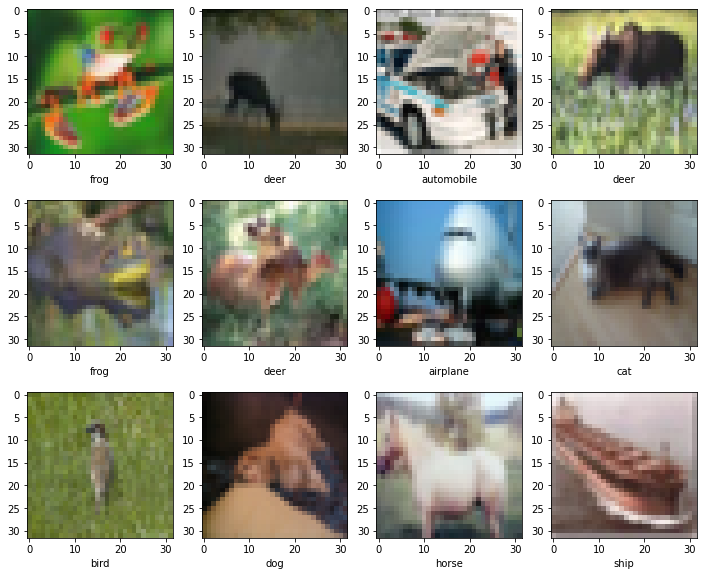

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [5]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [6]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [7]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3729, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [8]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [9]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [10]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 2.418s
  training loss (in-iteration): 	2.031550
  validation accuracy: 			33.30 %
Epoch 2 of 100 took 2.610s
  training loss (in-iteration): 	1.859631
  validation accuracy: 			36.34 %
Epoch 3 of 100 took 2.929s
  training loss (in-iteration): 	1.788787
  validation accuracy: 			38.75 %
Epoch 4 of 100 took 2.766s
  training loss (in-iteration): 	1.739142
  validation accuracy: 			39.76 %
Epoch 5 of 100 took 2.717s
  training loss (in-iteration): 	1.702356
  validation accuracy: 			40.86 %
Epoch 6 of 100 took 2.154s
  training loss (in-iteration): 	1.670529
  validation accuracy: 			40.23 %
Epoch 7 of 100 took 1.439s
  training loss (in-iteration): 	1.642502
  validation accuracy: 			43.31 %
Epoch 8 of 100 took 1.449s
  training loss (in-iteration): 	1.617549
  validation accuracy: 			43.98 %
Epoch 9 of 100 took 1.424s
  training loss (in-iteration): 	1.597100
  validation accuracy: 			44.63 %
Epoch 10 of 100 took 1.438s
  training loss (in-iteration): 	1.577229
  v

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [11]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		49.45 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [12]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1))
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('relu', nn.ReLU(inplace=True))
model.add_module('flatten', nn.Flatten())
model.add_module('linear1', nn.Linear(2560, 100))
model.add_module('relu', nn.ReLU(inplace=True))
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('linear2', nn.Linear(100, 10))

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_loss = []
val_accuracy = []

import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
        y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
                
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
        X_batch = X_batch.to(device)

        logits = model(X_batch)
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 8.536s
  training loss (in-iteration): 	1.645791
  validation accuracy: 			51.62 %
Epoch 2 of 100 took 2.024s
  training loss (in-iteration): 	1.327583
  validation accuracy: 			56.25 %
Epoch 3 of 100 took 2.042s
  training loss (in-iteration): 	1.220026
  validation accuracy: 			54.98 %
Epoch 4 of 100 took 2.037s
  training loss (in-iteration): 	1.156994
  validation accuracy: 			59.64 %
Epoch 5 of 100 took 2.023s
  training loss (in-iteration): 	1.114694
  validation accuracy: 			58.78 %
Epoch 6 of 100 took 1.994s
  training loss (in-iteration): 	1.080170
  validation accuracy: 			58.80 %
Epoch 7 of 100 took 2.059s
  training loss (in-iteration): 	1.052975
  validation accuracy: 			60.57 %
Epoch 8 of 100 took 2.024s
  training loss (in-iteration): 	1.029147
  validation accuracy: 			60.58 %
Epoch 9 of 100 took 2.020s
  training loss (in-iteration): 	1.013036
  validation accuracy: 			60.26 %
Epoch 10 of 100 took 2.003s
  training loss (in-iteration): 	1.000553
  v

KeyboardInterrupt: ignored

In [14]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    X_batch = X_batch.to(device)

    logits = model(X_batch)
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		60.54 %
Achievement unlocked: 70lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [15]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1))
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('bn1', nn.BatchNorm2d(num_features=10))
model.add_module('relu', nn.ReLU(inplace=True))
model.add_module('flatten', nn.Flatten())
model.add_module('linear1', nn.Linear(2560, 100))
model.add_module('bn2', nn.BatchNorm1d(num_features=100))
model.add_module('relu', nn.ReLU(inplace=True))
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('linear2', nn.Linear(100, 10))

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_loss = []
val_accuracy = []

import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
        y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
                
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
        X_batch = X_batch.to(device)

        logits = model(X_batch)
        y_pred = logits.max(1)[1].data.cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 4.109s
  training loss (in-iteration): 	1.468070
  validation accuracy: 			51.30 %
Epoch 2 of 100 took 4.525s
  training loss (in-iteration): 	1.238582
  validation accuracy: 			55.66 %
Epoch 3 of 100 took 2.595s
  training loss (in-iteration): 	1.162712
  validation accuracy: 			57.90 %
Epoch 4 of 100 took 2.533s
  training loss (in-iteration): 	1.108883
  validation accuracy: 			57.98 %
Epoch 5 of 100 took 2.562s
  training loss (in-iteration): 	1.073275
  validation accuracy: 			56.19 %
Epoch 6 of 100 took 2.541s
  training loss (in-iteration): 	1.039776
  validation accuracy: 			58.91 %
Epoch 7 of 100 took 2.572s
  training loss (in-iteration): 	1.012944
  validation accuracy: 			60.48 %
Epoch 8 of 100 took 2.475s
  training loss (in-iteration): 	0.992238
  validation accuracy: 			45.29 %
Epoch 9 of 100 took 2.556s
  training loss (in-iteration): 	0.976068
  validation accuracy: 			57.93 %
Epoch 10 of 100 took 2.528s
  training loss (in-iteration): 	0.961349
  v

KeyboardInterrupt: ignored

In [17]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    X_batch = X_batch.to(device)

    logits = model(X_batch)
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		59.78 %
Achievement unlocked: 60lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [37]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [38]:
from torchvision.datasets import CIFAR10
train_dataset = CIFAR10("./cifar_data/", train=True, transform=transform_augment)
train_length, val_length = int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)
train_dataset, val_dataset  = torch.utils.data.random_split(train_dataset, [train_length, val_length])

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=128,
                                              shuffle=True,
                                              num_workers=4,
                                              pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=128,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)

X: <class 'torch.Tensor'> torch.Size([128, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([128])


NotImplementedError: ignored

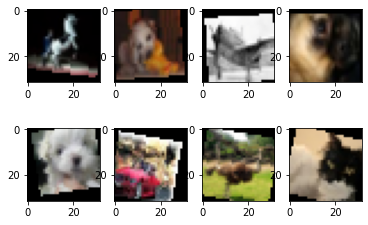

In [39]:

for (x_batch, y_batch) in train_dataloader:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [40]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_dataset = CIFAR10("./cifar_data/", train=False, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=500,
                                          shuffle=False,
                                          num_workers=0)

In [41]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1))
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('bn1', nn.BatchNorm2d(num_features=10))
model.add_module('relu', nn.ReLU(inplace=True))
model.add_module('flatten', nn.Flatten())
model.add_module('linear1', nn.Linear(2560, 100))
model.add_module('bn2', nn.BatchNorm1d(num_features=100))
model.add_module('relu', nn.ReLU(inplace=True))
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('linear2', nn.Linear(100, 10))

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


model.to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_loss = []
val_accuracy = []

import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

best_score = 0.
best_epoch = 0
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_dataloader:
        # train on batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
                
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_dataloader:
        X_batch = X_batch.to(device)

        logits = model(X_batch)
        y_pred = logits.max(1)[1].data.cpu()
        val_accuracy.append(torch.mean((y_batch == y_pred).to(float)))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 19.117s
  training loss (in-iteration): 	1.697580
  validation accuracy: 			44.41 %
Epoch 2 of 100 took 19.428s
  training loss (in-iteration): 	1.608733
  validation accuracy: 			45.32 %
Epoch 3 of 100 took 18.938s
  training loss (in-iteration): 	1.505535
  validation accuracy: 			46.14 %
Epoch 4 of 100 took 18.907s
  training loss (in-iteration): 	1.462236
  validation accuracy: 			47.24 %
Epoch 5 of 100 took 18.924s
  training loss (in-iteration): 	1.433862
  validation accuracy: 			47.72 %
Epoch 6 of 100 took 19.641s
  training loss (in-iteration): 	1.413054
  validation accuracy: 			49.05 %
Epoch 7 of 100 took 18.860s
  training loss (in-iteration): 	1.395082
  validation accuracy: 			50.05 %
Epoch 8 of 100 took 18.819s
  training loss (in-iteration): 	1.383412
  validation accuracy: 			51.10 %
Epoch 9 of 100 took 18.663s
  training loss (in-iteration): 	1.376896
  validation accuracy: 			51.36 %
Epoch 10 of 100 took 18.581s
  training loss (in-iteration): 	1.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    self._shutdown_workers()
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError  File "/usr/lib/python3.7/multiprocessing/process.py"

Epoch 29 of 100 took 20.345s
  training loss (in-iteration): 	1.301487
  validation accuracy: 			54.61 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>T

Epoch 30 of 100 took 20.804s
  training loss (in-iteration): 	1.296843
  validation accuracy: 			55.00 %


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>    self._shutdown_workers()
if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/lib

Epoch 31 of 100 took 20.503s
  training loss (in-iteration): 	1.295710
  validation accuracy: 			55.05 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2531f49950>

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
    Exception ignored in: if w.is_alive():      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in

Epoch 32 of 100 took 19.639s
  training loss (in-iteration): 	1.299434
  validation accuracy: 			54.88 %
Epoch 33 of 100 took 19.763s
  training loss (in-iteration): 	1.297596
  validation accuracy: 			54.74 %
Epoch 34 of 100 took 21.136s
  training loss (in-iteration): 	1.297427
  validation accuracy: 			54.91 %
Epoch 35 of 100 took 19.622s
  training loss (in-iteration): 	1.299203
  validation accuracy: 			54.80 %
Epoch 36 of 100 took 18.985s
  training loss (in-iteration): 	1.296239
  validation accuracy: 			54.85 %
Epoch 37 of 100 took 21.957s
  training loss (in-iteration): 	1.290925
  validation accuracy: 			55.38 %
Epoch 38 of 100 took 19.716s
  training loss (in-iteration): 	1.289870
  validation accuracy: 			55.38 %


KeyboardInterrupt: ignored

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    X_batch = X_batch.to(device)

    logits = model(X_batch)
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


The simplest setup to get above 80% accuracy is presented below.
All we need are:
* ResNet18 architecture 
* Light augmentations (random crop with paddind 4 and random horizontal flip) 
* Normalization (precomputed statistics)
* Classic CrossEntropyLoss
* SGD optimizer with 0.1 lr, 0.9 momentum
* Weight decay (1e-4)
* CosineAnnealing scheduler

In [6]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms


class ConvBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out
            

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        in_planes = 64
        planes = 64
        stride = 1
        for i in range(1, 5):
            layer = nn.Sequential(
                ConvBlock(in_planes, planes, stride=stride),
                ConvBlock(planes, planes, stride=1)
            )
            self.add_module(f'layer{i}', layer)
            
            in_planes = planes
            planes = planes * 2
            stride = 2

        self.linear = nn.Linear(in_planes, num_classes)

        self.relu = nn.ReLU(inplace=True)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=4)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [9]:
batch_size = 128

In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_loss = []
val_accuracy = []

import time
num_epochs = 100 # total amount of full passes over training data

best_val_acc = 0.
num_epoch_without_rise = 0 
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for step, (X_batch, y_batch) in enumerate(train_dataloader):
        # train on batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
    scheduler.step()
                
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)

        logits = model(X_batch)
        y_pred = logits.max(1)[1].data.cpu()
        val_accuracy.append(torch.mean((y_batch == y_pred).to(float)))
    
    epoch_loss = np.mean(train_loss[-len(train_dataset) // batch_size :])
    epoch_val_acc = np.mean(val_accuracy[-len(test_dataset) // batch_size :]) * 100

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(epoch_loss))
    print("  validation accuracy: \t\t\t{:.2f} %".format(epoch_val_acc))

    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        num_epoch_without_rise = 0 
    else:
        num_epoch_without_rise += 1
        if num_epoch_without_rise > 20:
            print(f'Early stopping at epoch {epoch + 1}.')

Epoch 1 of 100 took 46.200s
  training loss (in-iteration): 	1.843369
  validation accuracy: 			45.37 %
Epoch 2 of 100 took 45.521s
  training loss (in-iteration): 	1.588910
  validation accuracy: 			50.99 %
Epoch 3 of 100 took 45.671s
  training loss (in-iteration): 	1.275552
  validation accuracy: 			58.09 %
Epoch 4 of 100 took 45.528s
  training loss (in-iteration): 	1.001327
  validation accuracy: 			64.98 %
Epoch 5 of 100 took 45.575s
  training loss (in-iteration): 	0.811068
  validation accuracy: 			69.97 %
Epoch 6 of 100 took 45.509s
  training loss (in-iteration): 	0.687721
  validation accuracy: 			73.84 %
Epoch 7 of 100 took 47.036s
  training loss (in-iteration): 	0.608192
  validation accuracy: 			76.63 %
Epoch 8 of 100 took 46.547s
  training loss (in-iteration): 	0.557297
  validation accuracy: 			77.54 %
Epoch 9 of 100 took 45.498s
  training loss (in-iteration): 	0.526350
  validation accuracy: 			76.69 %
Epoch 10 of 100 took 45.597s
  training loss (in-iteration): 	0.

KeyboardInterrupt: ignored

In [18]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_dataloader:
    X_batch = X_batch.to(device)

    logits = model(X_batch)
    y_pred = logits.max(1)[1].data.cpu()
    test_batch_acc.append(torch.mean((y_batch == y_pred).to(float)))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		83.17 %
Achievement unlocked: 110lvl Warlock!
